In [26]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval
 
num_models = 50
           
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ['gender', 'race', 'lunch', 'test_preparation_course', 'education']
target = ['outcome']
categoricals = ['gender', 'race', 'education', 'lunch', 'test_preparation_course'] 

In [54]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/students-performance-in-exams/StudentsPerformance.csv')
# Prior knowledge knows that the test prep comes before the outcome.
df = df.rename(index=str, columns={"reading score": "reading_score", "writing score": "writing_score",  "math score": "math_score",
                              "test preparation course": "test_preparation_course", "parental level of education": "education", "race/ethnicity" : "race"
                             })
#return a list of encoders and an updated dataframe
label_encoder_list = []
#one_hot = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for i,col in enumerate(categoricals):
    label_encoder_list.append(LabelEncoder())
    df[col] = label_encoder_list[i].fit_transform(df[col].values)
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
df['math_score'] = normalize(df['math_score'])
df['writing_score'] = normalize(df['writing_score'])
df['reading_score'] = normalize(df['reading_score'])

outcome  = df['math_score'].values + df['reading_score'].values + df['writing_score'].values
cutoff = 2.2

outcome[outcome < cutoff] = 0
outcome[outcome>= cutoff] = 1

df.reset_index(inplace = True,drop = True)
df = df.join(pd.DataFrame(outcome, columns = ['outcome']))
df = df.drop(columns = ['reading_score', 'writing_score', 'math_score'])


In [55]:
np.count_nonzero(outcome)

300

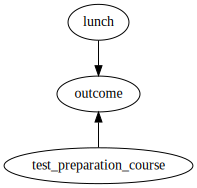

In [56]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 5,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
    

tempForbid = p.ForbiddenWithin(['outcome'])
temporal = [inputs, target]
prior = p.knowledge( addtemporal = temporal)


g = examine_graph_discrete(df, prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)


SVG(svg_str)



In [57]:

# let's split our df into two by race.  Let's see what happens if we 
original_df = df.copy()


df_test = df[df['race'] == 1].copy()

#works
'''
df_test = df[df['test_preparation_course'] == 0][:300].copy()
'''

#slightly
'''
df_test = df[(df['lunch'] == 0) & (df['test_preparation_course'] == 1)][:200].copy()
df_test = df[df['lunch'] == 0][:300].copy()
'''

#does not works
#df_test = df[df['race'] == 2].copy()
#df_test = df[df['test_preparation_course'] == 1].copy()

df.drop(df_test.index, inplace = True)
df_test.reset_index(inplace = True)
df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

x_test = df_test[inputs]
y_test = df_test[target]

causal_split = 0.2
val_split = 0.2
train_split = 1 - (causal_split + val_split)

x_causal = df[inputs][-int(causal_split * len(df)) :]
y_causal = df[target][-int(causal_split * len(df)) :]

x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

x_train = df[inputs][:int(train_split * len(df))]
y_train = df[target][:int(train_split * len(df))]
len(x_causal), len(y_causal), len(x_val), len(y_val), len(x_train), len(y_train)


        
x_test_NN = make_categorical(x_test, original_df, categoricals)
x_causal_NN = make_categorical(x_causal, original_df, categoricals)
x_val_NN = make_categorical(x_val, original_df, categoricals)
x_train_NN = make_categorical(x_train, original_df, categoricals)


y_test_NN = make_categorical(y_test, original_df, target)
y_causal_NN = make_categorical(y_causal, original_df, target)
y_val_NN = make_categorical(y_val, original_df, target)
y_train_NN = make_categorical(y_train, original_df, target)

models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/e' + str(i))

print(models, model_names)


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/e0', 'temp/e1', 'temp/e2', 'temp/e3', 'temp/e4', 'temp/e5', 'temp/e6', 'temp/e7', 'temp/e8', 'temp/e9', 'temp/e10', 'temp/e11', 'temp/e12', 'temp/e13', 'temp/e14', 'temp/e15', 'temp/e16', 'temp/e17', 'temp/e18', 'temp/e19', 'temp/e20', 'temp/e21', 'temp/e22', 'temp/e23', 'temp/e24', 'temp/e25', 'temp/e26', 'temp/e27', 'temp/e28', 'temp/e29', 'temp/e30', 'temp/e31', 'temp/e32', 'temp/e33', 

In [58]:
verbosity = 0
def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(2, activation = 'softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='categorical_crossentropy', metrics = ['accuracy'])
        #print(len(X), len(y))
        model.fit(x_train_NN, y_train_NN, epochs = 20, validation_data = (x_val_NN, y_val_NN), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)
        
        
        
def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

violation = []
generalization = []
metrics = []
proposed = []
x_causal.reset_index(drop = True, inplace = True)

for idx, model_name in enumerate(model_names):
    print(model_name)
    if type(models[idx]) is list:
        keras.backend.clear_session()
        model = load_model(model_name)
    else:
        model = models[idx]

    y_pred = model.predict(x_test_NN)
    generalization.append(roc_auc_score(y_test,y_pred[:,1]))
    
    #### CHECK FOR CAUSAL METRIC HERE
    y_causal_pred = model.predict(x_causal_NN)[:,1]
    metrics.append(roc_auc_score(y_causal, y_causal_pred))
    y_causal_pred[y_causal_pred > 0.5] = 1
    y_causal_pred[y_causal_pred <= 0.5] = 0
    causal_targets = pd.DataFrame(y_causal_pred, columns = target)
    causal_targets.reset_index(drop=True, inplace = True)
    causal_df = x_causal.join(causal_targets)
    
    
    

    #print(x_causal.head)
    bic_pred = get_bic(causal_df, prior)
    print(bic_pred, tetrad.getEdges())
    
    found_conx = set({})
    for i in tetrad.getEdges():
        if ' --> ' in i:
            found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
    found_conx

    if found_conx == known_conx:
        proposed.append(bic_pred)
        violation.append(0)
    else:
        print("******Found an error")
        # for now just remove bad model.  Will need to add it to distance metric.
        #proposed.append(bic_pred)
        #violation.append(1)
        metrics = metrics[:-1]
        generalization = generalization[:-1]

temp/e0
temp/e1
temp/e2
temp/e3
temp/e4
temp/e5
temp/e6
temp/e7
temp/e8
temp/e9
temp/e10
temp/e11
temp/e12
temp/e13
temp/e14
temp/e15
temp/e16
temp/e17
temp/e18
temp/e19
temp/e20
temp/e21
temp/e22
temp/e23
temp/e24
temp/e25
temp/e26
temp/e27
temp/e28
temp/e29
temp/e30
temp/e31
temp/e32
temp/e33
temp/e34
temp/e35
temp/e36
temp/e37
temp/e38
temp/e39
temp/e40
temp/e41
temp/e42
temp/e43
temp/e44
temp/e45
temp/e46
temp/e47
temp/e48
temp/e49
temp/e0
-874.3222654925183 ['test_preparation_course --> outcome', 'lunch --> outcome']
temp/e1
-869.6494366580564 ['test_preparation_course --> outcome', 'lunch --> outcome']
temp/e2
-860.7548496205798 ['lunch --> outcome', 'test_preparation_course --> outcome']
temp/e3
-878.4780186828692 ['test_preparation_course --> outcome', 'lunch --> outcome']
temp/e4
-874.3222654925183 ['test_preparation_course --> outcome', 'lunch --> outcome']
temp/e5
-874.3222654925183 ['test_preparation_course --> outcome', 'lunch --> outcome']
temp/e6
-860.7548496205798 ['lun

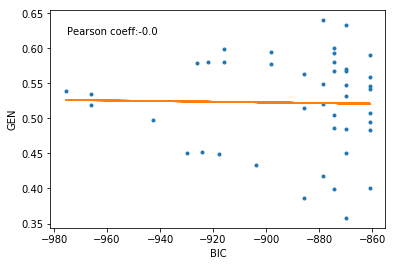

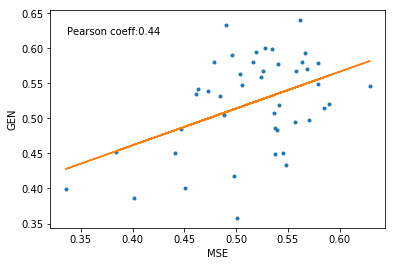

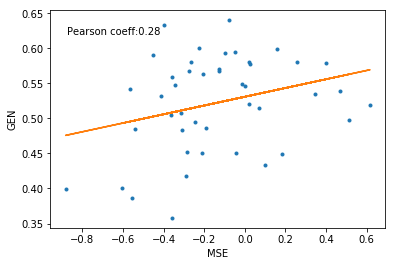

In [59]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) - normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [60]:
nbest = 5
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.mean(final.nlargest(nbest, 'metrics')['generalization']))
print("BIC = ", np.mean(final.nlargest(nbest, 'proposed')['generalization']))
print("COMB = ",np.mean(final.nlargest(nbest, 'combined')['generalization']))

MSE =  0.5418338907469342
BIC =  0.5237179487179486
COMB =  0.5340301003344482
